In [3]:
!pip install git+https://github.com/jaxleyverse/jaxley.git@1.0.0

  Cloning https://github.com/jaxleyverse/jaxley.git (to revision 1.0.0) to /tmp/pip-req-build-f9fr8sev
  Running command git clone --filter=blob:none --quiet https://github.com/jaxleyverse/jaxley.git /tmp/pip-req-build-f9fr8sev
  Running command git checkout -b 1.0.0 --track origin/1.0.0
  Switched to a new branch '1.0.0'
  Branch '1.0.0' set up to track remote branch '1.0.0' from 'origin'.
  Resolved https://github.com/jaxleyverse/jaxley.git to commit 2b4b715454f61426145a2bff4d1da793d5cce18e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Building single-cell models in Jaxley

In this first section of the tutorial, you will learn the basics of Jaxley and how to build single-cell models.

Some typical imports for using `Jaxley` are as follows. We will use these functions for the first section of our tutorial.

In [4]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np

import jaxley as jx

import pandas as pd
pd.set_option("display.max_columns", 50)

# Before we get started

Before getting started, we first need to access the data on google cloud:

In [5]:
from google.cloud import storage

client = storage.Client()
bucket = client.bucket("sjcabs_2025_data")

# Get access to the morphology file of an HSE cell.
blob = bucket.blob("jaxley/hse_10016_um.swc")
blob.download_to_filename("hse_10016_um.swc")

## Building single-cell models

In this part of the tutorial, we build a morphologically detailed model of an HSE cell in the optic lobe of a fruit fly. We can read such a cell from an SWC file (this will take around 45 seconds):

In [6]:
cell = jx.read_swc("hse_10016_um.swc", ncomp=1)

We can visualize this cell as follows:

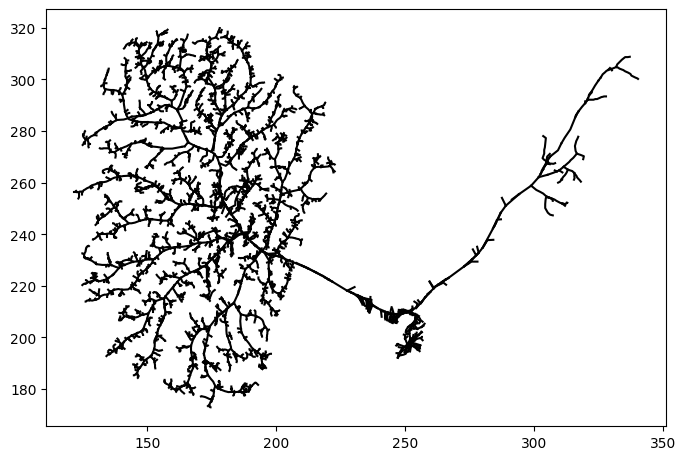

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cell.vis(ax=ax)
ax.set_aspect("equal")

Any `cell` (or `network`) in `Jaxley` tracks its parameters in two `pandas` Dataframes: `nodes` (for cellular parameters) and `edges`.
`nodes` contains all the information that we associate with cellular properties in the model and `edges` tracks all the information relevant to synapses.

For example:

In [8]:
cell.nodes

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,area,volume,resistive_load_in,resistive_load_out,x,y,z,global_cell_index,global_branch_index,global_comp_index,controlled_by_param,axon,undefined
0,0,0,0,10.553872,0.469325,5000.0,1.0,-70.0,32.071194,8.201524,32.622410,10.192478,336.362977,302.567442,293.400558,0,0,0,0,False,True
1,0,1,0,2.057679,0.832210,5000.0,1.0,-70.0,10.979268,4.508716,0.437690,0.530084,330.773648,304.366971,292.607286,0,1,1,0,False,True
2,0,2,0,1.232636,0.642159,5000.0,1.0,-70.0,4.977941,1.597759,0.457085,0.495982,329.226400,303.824000,292.535600,0,2,2,0,True,False
3,0,3,0,4.339637,0.593055,5000.0,1.0,-70.0,16.325665,4.836883,2.037871,1.999043,326.938406,302.358634,292.412228,0,3,3,0,False,True
4,0,4,0,1.490406,0.619093,5000.0,1.0,-70.0,5.797494,1.794593,0.618890,0.618890,325.253200,300.089200,293.004000,0,4,4,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876,0,3876,0,1.417124,0.479058,5000.0,1.0,-70.0,4.265562,1.021727,0.982768,0.982768,321.669600,294.332400,293.696000,0,3876,3876,0,False,True
3877,0,3877,0,1.444880,0.192000,5000.0,1.0,-70.0,1.743063,0.167334,6.238060,6.238060,321.868761,294.774917,292.821983,0,3877,3877,0,False,True
3878,0,3878,0,1.094178,0.397510,5000.0,1.0,-70.0,2.732854,0.543169,1.102075,1.102075,328.956800,304.024400,292.224000,0,3878,3878,0,False,True
3879,0,3879,0,0.853791,0.298038,5000.0,1.0,-70.0,1.598835,0.238257,1.529774,1.529774,329.933600,303.735600,292.919600,0,3879,3879,0,False,True


The units of each of these values can be found [here](https://jaxley.readthedocs.io/en/latest/faq/question_01.html).

### Views

Since `Cell`s can become very complex, Jaxley utilizes `View`s to make working with them easy and intuitive.

The simplest way to navigate Modules is as follows:

In [9]:
cell.branch(0)

View with 0 different channels. Use `.nodes` for details.

Views behave very similarly to the `Cell`, i.e. `cell.branch(0)` (the 0th branch of the cell) behaves like the `cell` we instantiated earlier. As such, `cell.branch(0)` also has a `nodes` attribute, which keeps track of its part of the cell:

In [10]:
cell.branch(0).nodes

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,area,volume,resistive_load_in,resistive_load_out,x,y,z,axon,undefined,global_cell_index,global_branch_index,global_comp_index,controlled_by_param
0,0,0,0,10.553872,0.469325,5000.0,1.0,-70.0,32.071194,8.201524,32.62241,10.192478,336.362977,302.567442,293.400558,False,True,0,0,0,0


You can use the `View` to visualize only parts of the cell, or highlights parts in different colors:

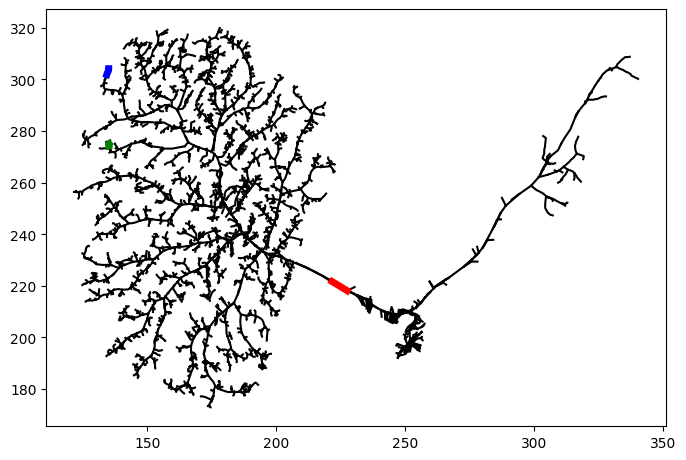

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cell.vis(ax=ax, color="k")
cell.branch(96).vis(ax=ax, color="r", linewidth=5.0)
cell.branch(502).vis(ax=ax, color="b", linewidth=5.0)
cell.branch(602).vis(ax=ax, color="g", linewidth=5.0)
_ = ax.set_aspect("equal")

More information on creating views can be found in [this tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/00_jaxley_api.html) on the `Jaxley` documentation website.

### Channels

Next, we turn to simulating this cell. By default `Jaxley` initializes cells without any ion channels in the membrane and simulates the voltage according to the cable equation
$$
C \frac{\text{d}V}{\text{d}t} = \frac{1}{r_a} \frac{\text{d}^2V}{\text{d}x^2},
$$

where $x$ is a location in space, and $r_a$ is the axial resistivity, which defines how strongly voltage is attenuated between nearby locations.

To make the cell more interesting, we want to `insert` ion channels. For this purpose `Jaxley` implements `Channel`s that can be inserted into any branch of the cell using the `insert` method of a `Cell` or a `View`. In this example, we use passive dynamics, which are implemented with the `Leak` channel:

$$
C \frac{\text{d}V}{\text{d}t} = \overline{g}_{\text{leak}} (E_{\text{leak}} - V) + r_a \frac{\text{d}^2V}{\text{d}x^2}
$$


In [12]:
from jaxley.channels import Leak

cell.insert(Leak())  # This inserts a `Leak` channel into all compartments of the cell.

> This is also were `View`s come in handy, as it allows to easily target the insertion of channels to specific compartments, for example:
```python
from jaxley.channels import Na, K
cell.branch(0).insert(Na)
```

You can also implement your own channels. This is explained [here](https://jaxley.readthedocs.io/en/latest/tutorials/05_channel_and_synapse_models.html).

### Changing parameters

Next, we have to adjust parameters of the simulation. In particular, this cell has two important free parameters:

- the strength of the leak channel ($\overline{g}_{\text{Leak}}$) defines how much current "leaks" out of the cell at any location (high $\overline{g}_{\text{Leak}} \rightarrow$ lots of leak)
- the axial resistivity describes how strongly neighboring parts of the cell are coupled to each other (high $r_a \rightarrow$ strong attenuation, i.e. weak coupling)

Here, we will use parameters that [Meier & Borst (Fig 3b)](https://www.cell.com/current-biology/fulltext/S0960-9822(19)30398-7) used for a multicompartment model of a CT1 cell. You can change parameters of your `Cell` with the `.set()` method:

In [13]:
cell.set("axial_resistivity", 400.0)  # Unit: ohm cm.
cell.set("Leak_gLeak", 1 / 8_000)  # Unit: S / cm2
cell.set("Leak_eLeak", -70.0)  # Unit: mV

> Feel free to inspect `cell.nodes` to check whether the `.set()` was successful.

> Feel free to modify other parameters. Have a look at `cell.nodes` for all things that can be changed. For example, you can modify the `capacitance` (default value is `1.0`).

### Stimulating, recording, and simulating the cell

We will now set up a simulation of the network.

In [14]:
# Stimulus.
i_delay = 20.0  # ms
i_amp = 0.1  # nA
i_dur = 100.0  # ms

# Duration and step size.
dt = 1.0  # ms
t_max = 200.0  # ms

time_vec = np.arange(0.0, t_max + dt, dt)

We stimulate the neuron in a branch of its dendrite (the blue branch above). We will record the voltage from the same branch, from a neighboring branch (green above), and from the soma fiber (red above):

In [15]:
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)

cell.delete_stimuli()
cell.branch(502).stimulate(current)  # branch(502) -> dendrite

cell.delete_recordings()
cell.branch(502).record()  # branch(502) -> dendrite
cell.branch(602).record()  # branch(602) -> neighboring dendrite
cell.branch(96).record()  # branch(96) -> soma fiber

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


Finally, we can run the simulation and plot the result:

In [16]:
voltages = jx.integrate(cell, delta_t=dt)

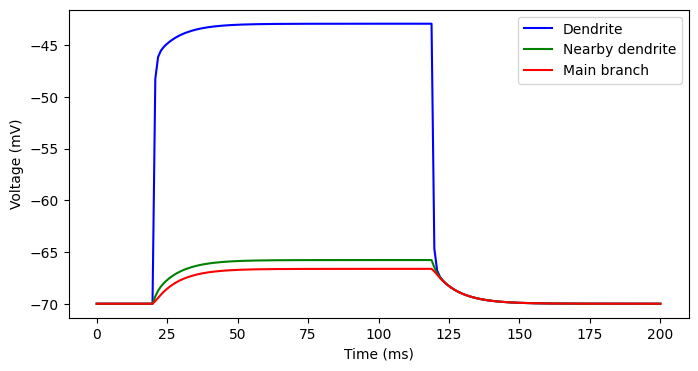

In [17]:
time_vector = np.linspace(0, t_max, voltages.shape[1])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
_ = ax.plot(time_vector, voltages[0], color="b")
_ = ax.plot(time_vector, voltages[1], color="g")
_ = ax.plot(time_vector, voltages[2], color="r")
_ = ax.legend(["Dendrite", "Nearby dendrite", "Main branch"])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

As you can see, the voltage gets strongly attenuated from the stimulation site (blue) to other parts of the morphology.

### Tasks for participants

1) Decrease the leak conductance (see above: `cell.set("Leak_gLeak", 1 / 8_000)`) and see how it impacts the simulation result.  
2) Decrease the axial resistivity (see above: `cell.set("axial_resistivity", 200.0)`) and see how it impacts the simulation result.  
3) Changing both of the above, can you get a visible response in the main branch?

# Part II: Building a mini-connectome network simulation

In this section of the tutorial, you will learn how to simulate networks models in `Jaxley`.

In [18]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import pickle
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import Leak

import pandas as pd
pd.set_option("display.max_columns", 50)

### Building a mini-connectome model

For this example, we will use a small sub-connectome which describes a few columns in the optic lobe. The network consists of 925 neurons and ~7302 synapses. Before getting started, we again must access the connectomic data on google cloud:

In [19]:
from google.cloud import storage

client = storage.Client()
bucket = client.bucket("sjcabs_2025_data")

# Get access to the connectomic data.
blob = bucket.blob("jaxley/malecns_09_optic_lobe_hex_08_meta.feather")
blob.download_to_filename("malecns_09_optic_lobe_hex_08_meta.feather")
blob = bucket.blob("jaxley/malecns_09_optic_lobe_hex_08_simple_edgelist.feather")
blob.download_to_filename("malecns_09_optic_lobe_hex_08_simple_edgelist.feather")

To get started, we will extract the nodes (neurons) and edges (connections) from the `.feather` files and extract some parts (e.g., photoreceptors) that we will use later.

In [20]:
# Read the nodes and edges of a connectome.
nodes = pd.read_feather("malecns_09_optic_lobe_hex_08_meta.feather")
edges = pd.read_feather("malecns_09_optic_lobe_hex_08_simple_edgelist.feather")

# Reset the indices of the `edges` dataframe (because `pre` and `post`
# use the indices within the _whole_ connectome, not just our small sub-connectome).
id_to_idx = pd.Series(nodes.index.to_numpy(), index=nodes["malecns_09_id"])
id_to_idx.index = id_to_idx.index.astype(edges["pre"].dtype, copy=False)
edges["pre"] = edges["pre"].map(id_to_idx)
edges["post"] = edges["post"].map(id_to_idx)

# Extract the cell-indices of some parts of the connectome which we will use in this simulation.
excitatory_indices = nodes.query("neurotransmitter_predicted == 'acetylcholine'").index.to_numpy()
inhibitory_indices = nodes.query("neurotransmitter_predicted == 'glutamate'").index.to_numpy()
unknown_indices = nodes.query("neurotransmitter_predicted == 'unclear'").index.to_numpy()
t4_indices = nodes.query("cell_type in ['T4a', 'T4b', 'T4c', 'T4d']").index.to_numpy()
photoreceptors_indices = nodes.query("cell_type in ['R1-R6', 'R8_unclear', 'R7_unclear', 'R8y', 'R7y', 'R7p']").index.to_numpy()

Now, let's build a connectome simulation in `Jaxley`. First, we create a network containing as many cells as there are in our connectome:

In [21]:
point_neuron = jx.Cell()
num_cells = len(nodes)
net = jx.Network([point_neuron for _ in range(num_cells)])

Secondly, we create groups. This is optional, but it makes it easier to interact with the network later on. For this, we will use the indices we defined above:

In [22]:
net.cell(excitatory_indices).add_to_group("excitatory")
net.cell(inhibitory_indices).add_to_group("inhibitory")
net.cell(unknown_indices).add_to_group("unkonwn")
net.cell(t4_indices).add_to_group("t4")
net.cell(photoreceptors_indices).add_to_group("photoreceptors")

After having defined the groups, we can now, for example, easily inspect all photoreceptors:

In [23]:
net.photoreceptors.nodes[:5]

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,area,volume,resistive_load_in,resistive_load_out,x,y,z,excitatory,inhibitory,unkonwn,t4,photoreceptors,global_cell_index,global_branch_index,global_comp_index,controlled_by_param
97,0,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,1.591549,1.591549,5.0,0.0,0.0,False,False,True,False,True,97,97,97,0
178,1,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,1.591549,1.591549,5.0,0.0,0.0,False,False,False,False,True,178,178,178,0
181,2,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,1.591549,1.591549,5.0,0.0,0.0,False,False,True,False,True,181,181,181,0
182,3,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,1.591549,1.591549,5.0,0.0,0.0,False,False,True,False,True,182,182,182,0
194,4,0,0,10.0,1.0,5000.0,1.0,-70.0,62.831853,31.415927,1.591549,1.591549,5.0,0.0,0.0,False,False,True,False,True,194,194,194,0


At this point, the network does not yet connected by any synapses. Let's fix this by using the `edges` dataframe and the `connect` method of `Jaxley`:

In [24]:
from jaxley.synapses import DynamicSynapse
from jaxley.connect import connect

pre_cells = net.select(nodes=edges["pre"].to_numpy())
post_cells = net.select(nodes=edges["post"].to_numpy())
connect(pre_cells, post_cells, DynamicSynapse())

Above, we used a `DynamicSynapse`, which implements the following synapse model:
    
$$
I = \overline{g} \cdot s \cdot (E - V_{\text{post}})
$$
$$
\tau_s \frac{\text{d}s}{\text{d}t} = \sigma\Big((V_{\text{pre}} - V_{\text{thr}}) / \Delta \Big)- s
$$
`Jaxley` offers many other options, see [here](https://jaxley.readthedocs.io/en/beta/jaxley.html#synapses).

You can inspect synapses and their parameters via the `.edges` attribute:

In [25]:
net.edges

,global_edge_index,index_within_type,pre_index,post_index,type,type_ind,pre_locs,post_locs,DynamicSynapse_gS,DynamicSynapse_tau,DynamicSynapse_v_th,DynamicSynapse_delta,DynamicSynapse_s,controlled_by_param
0,0,0,116,860,DynamicSynapse,0,0.5,0.5,0.0001,5.0,-35.0,10.0,0.0,0
1,1,1,243,233,DynamicSynapse,0,0.5,0.5,0.0001,5.0,-35.0,10.0,0.0,0
2,2,2,244,409,DynamicSynapse,0,0.5,0.5,0.0001,5.0,-35.0,10.0,0.0,0
3,3,3,236,243,DynamicSynapse,0,0.5,0.5,0.0001,5.0,-35.0,10.0,0.0,0
4,4,4,236,233,DynamicSynapse,0,0.5,0.5,0.0001,5.0,-35.0,10.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7297,7297,7297,842,716,DynamicSynapse,0,0.5,0.5,0.0001,5.0,-35.0,10.0,0.0,0
7298,7298,7298,687,779,DynamicSynapse,0,0.5,0.5,0.0001,5.0,-35.0,10.0,0.0,0
7299,7299,7299,779,687,DynamicSynapse,0,0.5,0.5,0.0001,5.0,-35.0,10.0,0.0,0
7300,7300,7300,842,747,DynamicSynapse,0,0.5,0.5,0.0001,5.0,-35.0,10.0,0.0,0


Next, we have to specify single neuron dynamics. For this example, we will again use a passive model and insert only a `Leak` channel into all neurons of our network:

In [26]:
net.insert(Leak())

### Recordings and stimuli

Let's say we have obtained activity recordings from all T4 neurons in this network. Let's load these activity recordings:

In [35]:
blob = bucket.blob("jaxley/optic_lobe_v_recordings.pkl")
blob.download_to_filename("optic_lobe_v_recordings.pkl")

with open("optic_lobe_v_recordings.pkl", "rb") as handle:
    recordings = pickle.load(handle)

>  In this example, the activity recordings were generated by another simulation, so they are not "real" experimental recordings.

Will now want to test whether our connectome model matches these activity recordings. For this, we first tell `Jaxley` which neurons these voltages belong to and record their voltage:

In [30]:
net.delete_recordings()
net.t4.record()

Added 36 recordings. See `.recordings` for details.


The activity recordings were generated based on visual stimuli to nine neurons. To mimic these stimuli, we stimulate the photoreceptors in our network:

In [31]:
### STIMULI.
i_delay = 200.0
i_dur = 500.0
dt = 10.0
t_max = 1_000.0
_ = np.random.seed(0)
i_amps = np.random.rand(len(photoreceptors_indices)) * 0.01
stimuli = jx.datapoint_to_step_currents(i_delay, i_dur, i_amps, dt, t_max)

net.delete_stimuli()
net.photoreceptors.stimulate(stimuli)

Added 46 external_states. See `.externals` for details.


### Setting parameters

To further adjust the simulation, we change some of the parameters. Let's first modify synaptic parameters:

In [32]:
net.set("DynamicSynapse_s", 0.0)
net.set("DynamicSynapse_gS", 1e-5)
net.set("DynamicSynapse_v_th", -32.0)

net.excitatory.set("DynamicSynapse_e_syn", 10.0)
net.inhibitory.set("DynamicSynapse_e_syn", -70.0)
net.unkonwn.set("DynamicSynapse_e_syn", -30.0)

> For more details on how to flexibly set synaptic parameters (e.g., by cell type, or by pre-synaptic cell index,...), see [this tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/09_advanced_indexing.html).

We then also modify the passive parameters of our neurons:

In [33]:
input_resistances = 10_000
net.set("Leak_gLeak", 1 / input_resistances)
net.set("Leak_eLeak", -65.0)
net.set("v", -60.0)

> After modiying parameters, you can also inspect `net.nodes` (for cellular parameters) and `net.edges` (for synaptic parameters) to check if setting them worked as expected.

> You can also modify parameters of individual neurons by doing, for example: `net.cell(0).set("Leak_gLeak", 1e-4)`, or of inidividual synapses by doing `net.DynamicSynapse.edge(0).set("DynamicSynapse_s", 0.01)`.

### Simulating the model

We have now defined a small connectome model with a particular connectivity, as well as synaptic and cellular dynamics. Next, we will simulate this model and compare it to "experimental" activity recordings.

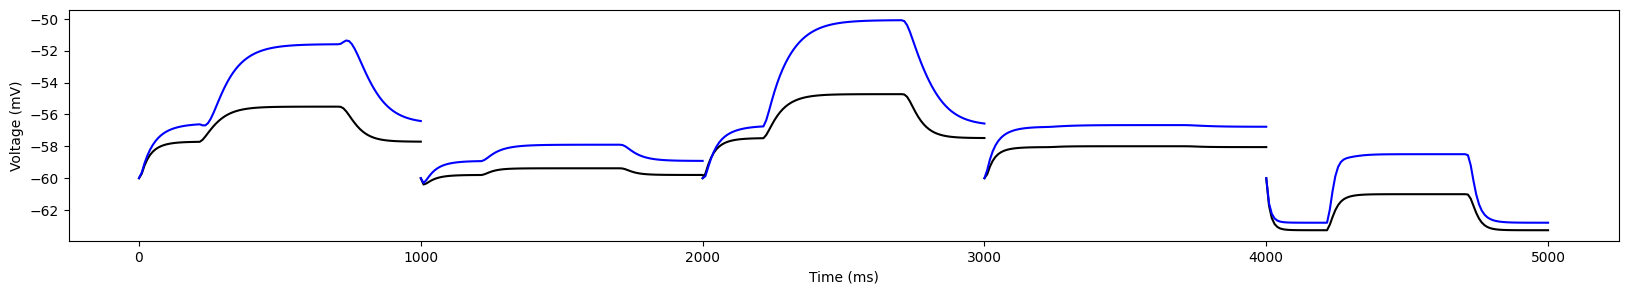

In [36]:
voltages = jx.integrate(net, delta_t=dt)

time_vector = np.linspace(0, t_max, voltages.shape[1])

fig, ax = plt.subplots(1, 1, figsize=(20, 3))
for neuron_id in range(5):
    _ = ax.plot(time_vector + neuron_id * 1000, voltages[neuron_id], color="k")
    _ = ax.plot(time_vector + neuron_id * 1000, recordings[neuron_id], color="b")
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

The match is clearly not perfect yet. In the rest of this tutorial, we will use gradient descent to optimize parameters of this network such that the voltage traces match.

### Tasks for participants

Modify the synaptic conductances (e.g., `ReluDynamicSynapse_gS`) or the cellular parameters (`Leak_gLeak` and `Leak_eLeak`). Inspect `net.nodes` and `net.edges` to see if things worked. Also check how the modifications impacts the modelled voltages.

> ⚠️ **_IMPORTANT_**: before moving on to the next parts of this tutorial, reset parameter values as follows:

In [37]:
net.set("DynamicSynapse_s", 0.0)
net.set("DynamicSynapse_gS", 1e-5)
net.set("DynamicSynapse_v_th", -32.0)

net.excitatory.set("DynamicSynapse_e_syn", 10.0)
net.inhibitory.set("DynamicSynapse_e_syn", -70.0)
net.unkonwn.set("DynamicSynapse_e_syn", -30.0)

input_resistances = 10_000
net.set("Leak_gLeak", 1 / input_resistances)
net.set("Leak_eLeak", -65.0)
net.set("v", -60.0)

# Part III: Training the connectome model

In the final part of this tutorial, you will learn how to train the network model such that it fits "experimental" activity recordings. This includes the following:

- compute the gradient with respect to parameters  
- use parameter transformations  
- define optimizers  

### Defining trainable parameters

To train such a network, we first have to indicate which values should be optimized. For this, we use the `.make_trainable()` method.

To make a single parameter trainable, run `make_trainable` on `net`. For example, for the leak reversal potential:

In [38]:
net.delete_trainables()

net.make_trainable("Leak_eLeak")

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1


Similarly, we also use a single (shared) parameter for the synaptic reversal potential of each cell type, and for the synaptic threshold:

In [39]:
net.excitatory.make_trainable("DynamicSynapse_e_syn")
net.inhibitory.make_trainable("DynamicSynapse_e_syn")
net.unkonwn.make_trainable("DynamicSynapse_e_syn")

net.make_trainable("DynamicSynapse_v_th")

Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Number of newly added trainable parameters: 1. Total number of trainable parameters: 5


We can also define parameters for individual cells or synapses. To do this, use the `"all"` key. The following defines a separate parameter for the leak conductance of every cell in the network:

In [40]:
net.select(nodes="all").make_trainable("Leak_gLeak")

Number of newly added trainable parameters: 925. Total number of trainable parameters: 930


And the following defines a single parameter for every synapse:

In [41]:
net.select(edges="all").make_trainable("DynamicSynapse_gS")

Number of newly added trainable parameters: 7302. Total number of trainable parameters: 8232


> For more flexile ways to share parameters (e.g., by cell-type), check out [this tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/10_advanced_parameter_sharing.html).

Once all parameters are defined, you can use `.get_parameters()` to obtain all trainable parameters.

In [42]:
params = net.get_parameters()

> Feel free to inspect the `params`. It contains one value for every trainable parameter.

### Defining a loss function

Before we define the loss, we compute the mean and standard deviations of the recorded voltages. These will be used such that the loss function is computed on outputs that are (roughly) standardized.

In [43]:
rec_mean = jnp.mean(recordings)
rec_std = jnp.std(recordings)
recordings_z_scored = (recordings - rec_mean) / rec_std

In addition, we also have to standardize (and possibly constrain) parameters. To do so, `Jaxley` provides parameter transformations:

In [44]:
import jaxley.optimize.transforms as jt

transform = jx.ParamTransform([
    {"Leak_eLeak": jt.SigmoidTransform(-70.0, -60.0)},
    {"DynamicSynapse_e_syn": jt.SigmoidTransform(-15.0, 15.0)},
    {"DynamicSynapse_e_syn": jt.SigmoidTransform(-80.0, -60.0)},
    {"DynamicSynapse_e_syn": jt.SigmoidTransform(-70.0, 0.0)},
    {"DynamicSynapse_v_th": jt.SigmoidTransform(-35.0, -25.0)},
    {"Leak_gLeak": jt.SigmoidTransform(5e-5, 2e-4)},
    {"DynamicSynapse_gS": jt.SigmoidTransform(0.0, 0.00002)},
])

These transformations are then used to standardize the parameters:

In [45]:
opt_params = transform.inverse(params)

We then define the loss: the mean square error between model voltages and experimental recordings:

In [46]:
def loss(opt_params):
    params = transform.forward(opt_params)
    trace = jx.integrate(net, params=params, delta_t=dt)
    prediction = (trace - rec_mean) / rec_std
    return jnp.mean((prediction - recordings_z_scored) ** 2)

jitted_grad = jit(value_and_grad(loss))

Note that, before passing parameters to the simulation (which is done by `simulate`), we de-standardize the parameters by running `params = transform.forward(opt_params)`.

We can use `JAX`'s inbuilt functions to take the gradient through the entire ODE:

In [47]:
prediction, gradient = jitted_grad(opt_params)

> Feel free to inspect the `gradient`. It contains one value for every trainable parameter and has the exact same structure as `params`.

### Training

We will use the ADAM optimizer from the [optax library](https://optax.readthedocs.io/en/latest/) to optimize the free parameters:

In [48]:
import optax

optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(opt_params)

### Training loop

That's it! We can now turn to training this network:

In [49]:
for iteration in range(1_000):
    loss_val, gradient = jitted_grad(opt_params)
    updates, opt_state = optimizer.update(gradient, opt_state)
    opt_params = optax.apply_updates(opt_params, updates)

    if iteration % 100 == 0:
        print(f"iteration {iteration}, loss {loss_val}")

final_params = transform.forward(opt_params)

iteration 0, loss 0.37412488872105903
iteration 100, loss 0.07356999418716235
iteration 200, loss 0.022075338531063658
iteration 300, loss 0.014202579957904107
iteration 400, loss 0.010754561022756862
iteration 500, loss 0.008530770807334026
iteration 600, loss 0.006946748507340683
iteration 700, loss 0.0057890573639356084
iteration 800, loss 0.004931601512491826
iteration 900, loss 0.004285996306324491


### Evaluation

Once the training has finished, we can evaluate the trained network. To this end, we simulate the model with the trained parameters and compare the simulated voltages to the experimental recordings.

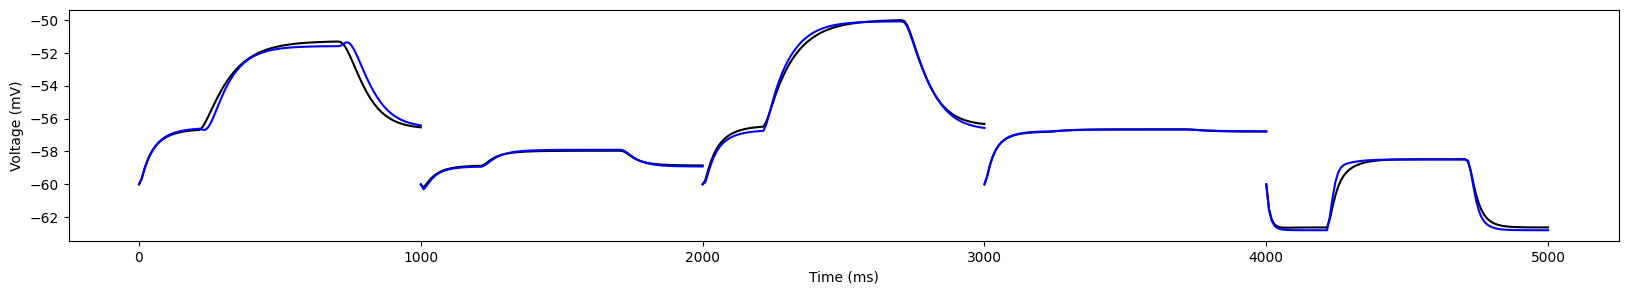

In [50]:
voltages = jx.integrate(net, params=final_params, delta_t=dt)

time_vector = np.linspace(0, t_max, voltages.shape[1])

fig, ax = plt.subplots(1, 1, figsize=(20, 3))
for neuron_id in range(5):
    _ = ax.plot(time_vector + neuron_id * 1000, voltages[neuron_id], color="k")
    _ = ax.plot(time_vector + neuron_id * 1000, recordings[neuron_id], color="b")
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

Indeed, the network now fits the recordings much better! Congrats!

### Tasks for participants

Increase the number of epochs that the network is trained for. Observe how the final accuracy changes when training for more epochs.  

## A note on identifyability

Since our activity recordings were generated by a simulation, we can inspect whether the learned parameters match the _actual_ parameters of the neural system. Let's first load the paramters that were used to generate the activity measurement:

In [51]:
blob = bucket.blob("jaxley/optic_lobe_input_resistances.pkl")
blob.download_to_filename("optic_lobe_input_resistances.pkl")

blob = bucket.blob("jaxley/optic_lobe_syn_strenghts.pkl")
blob.download_to_filename("optic_lobe_syn_strenghts.pkl")

with open("optic_lobe_input_resistances.pkl", "rb") as handle:
    input_resistances = pickle.load(handle)

with open("optic_lobe_syn_strenghts.pkl", "rb") as handle:
    syn_strenghts = pickle.load(handle)

For easier inspection, we write the trained parameters into the `net.nodes` and `net.edges` dataframes:

In [52]:
net.write_trainables(final_params)

We can then plot the learned parameters against the true parameters:

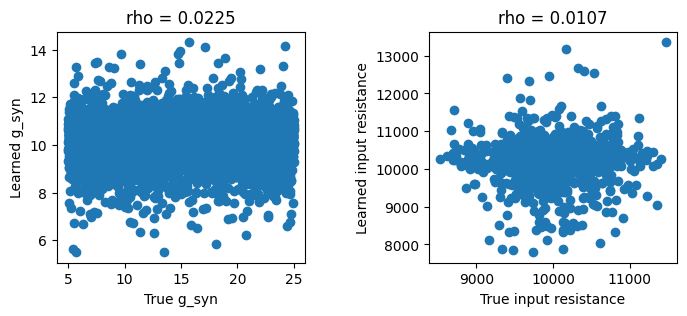

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
_ = ax[0].scatter(syn_strenghts * 1e6, net.edges["DynamicSynapse_gS"] * 1e6)
_ = ax[1].scatter(input_resistances, 1 / net.nodes["Leak_gLeak"])
_ = ax[0].set_xlabel("True g_syn")
_ = ax[0].set_ylabel("Learned g_syn")

_ = ax[0].set_title(f"rho = {np.corrcoef(syn_strenghts, net.edges["DynamicSynapse_gS"])[0, 1]:.4f}")
_ = ax[1].set_title(f"rho = {np.corrcoef(input_resistances, 1 / net.nodes["Leak_gLeak"])[0, 1]:.4f}")
_ = ax[1].set_xlabel("True input resistance")
_ = ax[1].set_ylabel("Learned input resistance")
plt.subplots_adjust(wspace=0.5)

Unfortunately, there is almost no correlation! This highlights that, while activity recordings might match, the _mechanisms_ used by our model might not yet be correct. There are many possibilities to alleviate this:
- One might train the model on larger datasets.
- One might use measurements of the parameters to constrain them (for example, use synaptic size to constrain the synaptic weight).
- One might share parameters if their values are believed to be similar (thereby reducing the total number of parameters).

# Summary

In this tutorial, we introduced Jaxley and how to build biophysical models. Further  information and features can be found in our tutorials online:

- [Basic tutorials](https://jaxley.readthedocs.io/en/latest/tutorials.html)
- [Advanced tutorials](https://jaxley.readthedocs.io/en/latest/advanced_tutorials.html)

For building connectome models, we believe that the following tutorials should be most helpful:
- [Building custom synapse and channel models](https://jaxley.readthedocs.io/en/latest/tutorials/05_channel_and_synapse_models.html)
- [Defining cell types or other groups](https://jaxley.readthedocs.io/en/latest/tutorials/06_groups.html)
- [Setting synaptic parameters](https://jaxley.readthedocs.io/en/latest/tutorials/09_advanced_indexing.html)
- [Sharing synaptic parameters](https://jaxley.readthedocs.io/en/latest/tutorials/10_advanced_parameter_sharing.html)

If you have any further questions, feel free to post on our [discussion forum](https://github.com/jaxleyverse/jaxley/discussions). Happy coding!